In [2]:
import cv2
import scipy
import pprint
import random
import itertools
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets
from collections import Counter
from skimage.feature import hog
from sklearn import preprocessing
from skimage import data
import keras
from sklearn.externals import joblib


import matplotlib
matplotlib.use('Agg')
%matplotlib auto

from matplotlib import pyplot as plt

Using matplotlib backend: TkAgg


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [195]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')#, data_home=custom_data_home)
data = mnist.data
target = mnist.target

# Generating 2-digit combinations

In [411]:
def remove_border(img):
    where = np.where(img > 0)
    y1 = np.min(where[0])
    y2 = np.max(where[0])
    x1 = np.min(where[1])
    x2 = np.max(where[1])
    crop = img[y1:y2 , x1:x2]
    return crop

from skimage.filters import threshold_otsu

i = 0
combs = []
combs_labels = []
data_w_labels = zip(data, target)

import random
random.shuffle(data_w_labels)

for comb in itertools.combinations(data_w_labels, 2):
    if i >= 1000000: break
        
    first_digit = comb[0][0].reshape((28, 28))
    second_digit = comb[1][0].reshape((28, 28))

    thresh = threshold_otsu(first_digit)
    first_digit = (first_digit > thresh).astype(np.uint8)
    
    thresh = threshold_otsu(second_digit)
    second_digit = (second_digit > thresh).astype(np.uint8)
    
    first_mod = remove_border(first_digit)
    second_mod = remove_border(second_digit)
    
    # Make sure height diff is divisible by 2
    if not (first_mod.shape[0] % 2 == 0):
        first_mod = np.vstack([first_mod, np.zeros((1, first_mod.shape[1]))])
    if not (second_mod.shape[0] % 2 == 0):
        second_mod = np.vstack([second_mod, np.zeros((1, second_mod.shape[1]))])
    
    height_diff = first_mod.shape[0] - second_mod.shape[0]
    
    if height_diff < 0:
        padding = int(-height_diff / 2.0)
        thepad = np.zeros((first_mod.shape[0], padding))
        first_mod = np.vstack([first_mod, thepad])
        first_mod = np.vstack([thepad, first_mod])
    elif height_diff > 0:
        padding = int(height_diff / 2.0)
        thepad = np.zeros((padding, second_mod.shape[1]))
        second_mod = np.vstack([second_mod, thepad])
        second_mod = np.vstack([thepad, second_mod])
    
    # Align width
    overlap = 1
    
    height = first_mod.shape[0]
    width_1 = first_mod.shape[1]
    width_2 = second_mod.shape[1]
    
    padding = np.zeros((height, width_2 - overlap))
    first_mod = np.hstack([first_mod, padding])
    padding = np.zeros((height, width_1 - overlap))
    second_mod = np.hstack([padding, second_mod])
    
    overlapped = first_mod.astype(np.uint64) + second_mod.astype(np.uint64)
    overlapped = np.clip(overlapped, 0, 255).astype(np.uint8)
    padded = np.pad(overlapped, (5, 5), 'constant', constant_values=(0, 0))  
    
    binary = (padded > 0).astype(np.uint8)
    combs.append(binary)
    
    label = int(  str(int(comb[0][1])) + str(int(comb[1][1]))  )
    combs_labels.append( label )
    i += 1
    
# combs = np.array(combs)
combs_labels = np.array(combs_labels)

In [434]:
combs_reshaped = [cv2.resize(x, (38, 28)) for x in combs]

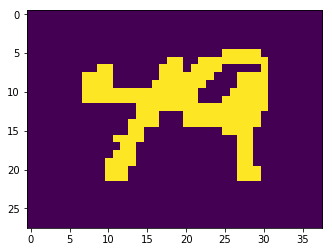

49

In [436]:
i = 851
plt.imshow(combs_reshaped[i])
plt.show()
combs_labels[i]

In [403]:
def plot_things(things, labels):
    count = len(things)
    plt.figure(figsize=(20, 20))
    
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    for i, thing in enumerate(things):
        cols = 10
        rows = int(count / cols) + 1
        ax = plt.subplot(rows, cols, 1 + i)
        
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(labels[i])

        plt.imshow(thing)
    plt.show()

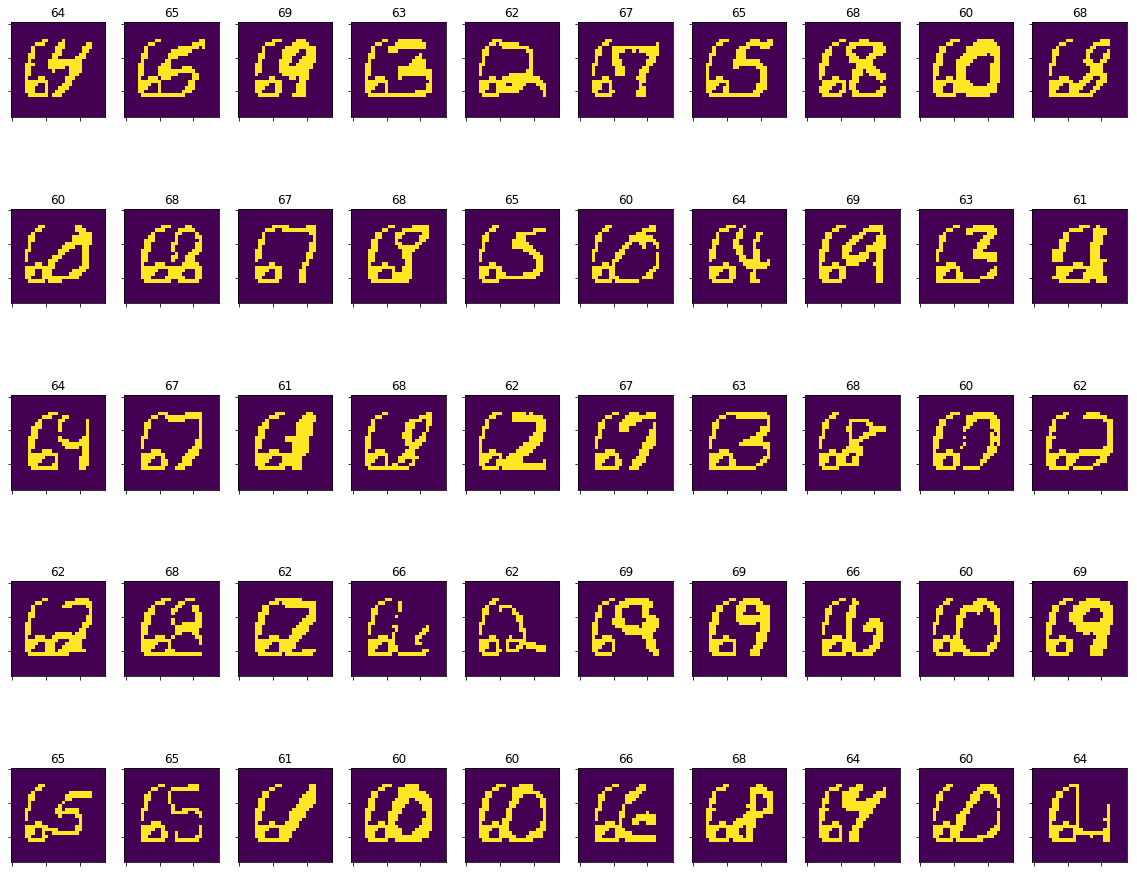

In [410]:
i = 100
plot_things(combs_reshaped[i:i + 50], combs_labels[i:i + 50])

# Train Classifier

In [437]:
from sklearn.cross_validation import train_test_split
from keras.utils.np_utils import to_categorical

# Extract the features and labels
combs_np = np.array(combs_reshaped)
features = np.expand_dims(combs_np.reshape(1000000, 28, 38), axis=3)
labels = to_categorical(combs_labels)

x_train, y_train, x_test, y_test = train_test_split(features, labels)

In [3]:
import keras
from keras import applications
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


def get_model():
    model = Sequential()

    model.add(Conv2D(32, (3,3), input_shape=(28, 38, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100))
    model.add(Activation('softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model


batch_size = 512
num_classes = 10
epochs = 7

model = get_model()

In [439]:
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

history_bn = model.fit(
    features,
    labels,
    validation_split=0.05,
    batch_size=batch_size,
    callbacks=[earlyStopping], 
    epochs=epochs
)

# Save the classifier
model.save(filepath='./double_digits_cnn')

Train on 950000 samples, validate on 50000 samples
Epoch 1/7
950000/950000 [==============================] - 336s - loss: 0.3541 - acc: 0.9017 - val_loss: 5.6276 - val_acc: 0.5877
Epoch 2/7
950000/950000 [==============================] - 332s - loss: 0.0763 - acc: 0.9773 - val_loss: 5.8614 - val_acc: 0.5914


# Test on Gels

In [4]:
clf, pp = joblib.load("digits_cls.pkl")
model = keras.models.load_model('./double_digits_cnn')

/usr/local/lib/python2.7/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.18.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
def sort_rects(rects_ctrs):
    rects_sort = sorted(rects_ctrs, key=lambda r: r[0][0])
    
    result = []
    for rect in rects_sort:
        # Filter to only rects with overlap of > 1/3 of target height
        rects_sort_filt = filter(lambda x: calc_overlap(x[0], rect[0]) > (x[0][3] / 3.0) and abs(x[0][3] - rect[0][3]) < (x[0][3]), rects_sort)
        rects_sort_filt = sorted(rects_sort_filt, key=lambda r: r[0][0])
        result += rects_sort_filt
        for rect_sorted in rects_sort_filt:
            rects_sort.remove(rect_sorted)
        
    return zip(*result)
    

def calc_overlap(rect_1, rect_2):
    rect_1_x = rect_1[0]
    rect_1_y = rect_1[1]
    rect_1_width = rect_1[2]
    rect_1_height = rect_1[3]
    
    rect_2_x = rect_2[0]
    rect_2_y = rect_2[1]
    rect_2_width = rect_2[2]
    rect_2_height = rect_2[3]
    
    overlap = min(rect_1_y + rect_1_height, rect_2_y + rect_2_height) - max(rect_1_y, rect_2_y)
    return overlap

In [8]:
def extract_numbers(im, thresh=80, blur=True):
    result = []
    
    im_one = im.astype(np.uint8)[:,:,2]

    # Convert to grayscale and apply Gaussian filtering
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_gray = (255 - im_one)
    if blur:
        im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

    # Threshold the image
    ret, im_th_all_colors = cv2.threshold(im_gray, thresh, 255, cv2.THRESH_BINARY)
    # Or try with black threshold
    lower, upper = boundaries['black']
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")
    mask = cv2.inRange(im, lower, upper)
    im_th = cv2.bitwise_and(im, im, mask = mask).astype(np.uint8)
    im_th = cv2.cvtColor(im_th, cv2.COLOR_BGR2GRAY)

    # Find contours in the image
    ctrs = cv2.findContours(im_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get contour bounding boxes
    rects = [cv2.boundingRect(ctr) for ctr in ctrs[1]]
    
    # Sorted order of rois
    sorted_rects, sorted_ctrs = sort_rects(zip(rects, ctrs[1]))

    probs = []
    date_possibs = []
    cur_date_possib = []
    prev_end_x = sorted_rects[0][0] + sorted_rects[0][2]
    prev_end_y = sorted_rects[0][1] + sorted_rects[0][3]
    j = 0
    # For each rectangular region, predict the digit using classifier
    for i, rect in enumerate(sorted_rects):
        x_start = rect[0]
        y_start = rect[1]
        width = rect[2]
        height = rect[3]

        # Skip short artifacts
        if height < 10: continue

        im_th_all_colors = im_th_all_colors.astype(np.float64)
        im_roi = im_th_all_colors[y_start : y_start + height, x_start : x_start + width]

        mask = np.zeros((height, width)).astype(np.uint8)
        
        mask = cv2.drawContours(mask, sorted_ctrs, i, (255, 255, 255), cv2.FILLED, offset=(-x_start, -y_start))
        roi = cv2.bitwise_and(mask.astype(np.uint8), im_roi.astype(np.uint8)).astype(np.uint8)

        # CNN
        if height < width:
            padding = int((width - height) / 2.0)
            roi_pad = np.pad(roi, (padding, padding), 'constant', constant_values=(0, 0))
        elif width < height:
            padding = int((height - width) / 2.0)
            roi_pad = np.pad(roi, (padding, padding), 'constant', constant_values=(0, 0))
        else:
            roi_pad = roi
        roi_pad = np.pad(roi_pad, (5, 5), 'constant', constant_values=(0, 0))

        roi_resized = cv2.resize(roi_pad, (38 ,28), interpolation=cv2.INTER_NEAREST)
        
        roi_cnn = np.expand_dims(roi_resized, axis=2)
        
        prob = model.predict_proba(np.array([roi_cnn]), verbose=0)
        nbr = np.argmax(prob)
        nbr_prob = prob[0]

        # SVM w. HOG feats
#         roi_hog_fd = calc_hog_feats(rect, roi)
#         if not hasattr(roi_hog_fd, 'shape'): continue
#         nbr = clf.predict(roi_hog_fd)
#         # Dummy prob
#         nbr_prob = 0

        if x_start - prev_end_x < 80 and y_start - prev_end_y < 80:
            cur_date_possib.append(nbr)
        else:
            date_possibs.append(cur_date_possib)
            cur_date_possib = [nbr]

        prev_end_x = x_start
        prev_end_y = y_start

        cv2.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 100, 255), 1)
        cv2.putText(im, str(int(nbr)) + '-', (rect[0], rect[1]), cv2.FONT_ITALIC, 0.4, (0, 0, 255), 1)
        
        # Only add if we are confident
#         class_prob = np.max(prob)
#         if class_prob > .9:
#         probs.append(class_prob)

#         if j == 6:
#             print(prob)
#             plt.imshow(roi_resized)
#             plt.show()
#             return
            
        probs.append(0)
        result.append((roi_resized, nbr))   
        
        j += 1
        
    date_possibs.append(cur_date_possib)
    
    plt.imshow(im)
    plt.show()
    
    return result, date_possibs, probs

In [10]:
imgs = [1,6,12,21,41,42,51,52,56,83,84,89,90,96,97,106,123,131,136,152,153,156,157] #7, 22
filenames = ['../data/gels_nov_2016/Im{} - p. {}.png'.format(i, i) for i in imgs]

images = [scipy.misc.imread(f) for f in filenames]

boundaries = {
#     ([30, 15, 20], [50, 40, 60]), # black ink
    'black': ([0, 0, 0], [190, 190, 190]), # black ink
    'blue': ([50, 31, 4], [85, 120, 180]), # blue dye
}

colors = []
image = scipy.misc.imread(filenames[0])
for bound in boundaries.keys():
    lower, upper = boundaries[bound]
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")

    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask = mask)
    colors.append(output)
    
    

im = scipy.misc.imread(filenames[8])#[580:880,440:980]   
roi = im[790:880,520:750]
# imgs = [roi]

results = [extract_numbers(i) for i in images[0:10]]

TclError: no display name and no $DISPLAY environment variable